<h1><center>DICOM Processing and Segmentation in Python</center></h1>

<img src="https://www.raddq.com/wp-content/uploads/2017/01/img_588d682734db4-1024x520.png" width="680" height="346" >

DICOM is a pain in the neck.  It also happens to be very helpful.  As clinical radiologists, we expect post-processing, even taking them for granted. However, the magic that occurs behind the scenes is no easy feat, so let’s explore some of that magic.

In this quest, we will be starting from raw DICOM images. We will extract voxel data from DICOM into numpy arrays, and then perform some low-level operations to normalize and resample the data, made possible using information in the DICOM headers.

The remainder of the Quest is dedicated to visualizing the data in 1D (by histogram), 2D, and 3D. Finally, we will create segmentation masks that remove all voxel except for the lungs.

Processing raw DICOM with Python is a little like excavating a dinosaur – you’ll want to have a jackhammer to dig, but also a pickaxe and even a toothbrush for the right situations. Python has all the tools, from pre-packaged imaging process packages handling gigabytes of data at once to byte-level operations on a single voxel.

## Import Packages

In [1]:
# %reload_ext signature
# %matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

### Setting paths
Then, let's specify a specific DICOM study we can take a closer look. Let's take a look at a chest CT stack from the first patient in the train.csv file given which has some slices that have Pulmonary Embolism (PE). Here we'll use the patient ID 6897fa9de148 from that dataset. 



In [2]:
patient_id = '6897fa9de148'
patient_folder = f'../input/rsna-str-pulmonary-embolism-detection/train/{patient_id}/'
data_paths = glob(patient_folder + '/*/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print (f'Total of {len(data_paths)} DICOM images.\nFirst 5 filenames:' )
data_paths[:5]


Total of 124 DICOM images.
First 5 filenames:


['../input/rsna-str-pulmonary-embolism-detection/train/6897fa9de148/2bfbb7fd2e8b/0de5072ee990.dcm',
 '../input/rsna-str-pulmonary-embolism-detection/train/6897fa9de148/2bfbb7fd2e8b/cef0f36a062e.dcm',
 '../input/rsna-str-pulmonary-embolism-detection/train/6897fa9de148/2bfbb7fd2e8b/be0b7524ffb4.dcm',
 '../input/rsna-str-pulmonary-embolism-detection/train/6897fa9de148/2bfbb7fd2e8b/3806459893c7.dcm',
 '../input/rsna-str-pulmonary-embolism-detection/train/6897fa9de148/2bfbb7fd2e8b/1fa18364e089.dcm']

## Helper function

Here we make two helper functions.

* `load_scan` will load all DICOM images from a folder into a list for manipulation.
* The voxel values in the images are raw. `get_pixels_hu` converts raw values into [Houndsfeld units](https://en.wikipedia.org/wiki/Hounsfield_scale)

    * The transformation is linear. Therefore, so long as you have a slope and an intercept, you can rescale a voxel value to HU.
    * Both the rescale intercept and rescale slope are stored in the DICOM header at the time of image acquisition (these values are scanner-dependent, so you will need external information).

In [3]:
#      
# Loop over the image files and store everything into a list.
# 

def load_scan(paths):
    slices = [pydicom.read_file(path ) for path in paths]
    slices.sort(key = lambda x: int(x.InstanceNumber), reverse = True)
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

## Save the loaded images in npy format

In [4]:
patient_id = '0003b3d648eb'
patient = load_scan(data_paths)
imgs = get_pixels_hu(patient)

#This is a good time to save the new data set to disk so we don't have to reprocess the stack every time.
np.save(f'fullimages_{patient_id}.npy', imgs)

### Displaying Images
The first thing we should do is to check to see whether the **Houndsfeld Units** are properly scaled and represented. HU's are useful because it is standardized across all CT scans regardless of the absolute number of photons the scanner detector captured. If you need a refresher, here's a quick list of a few useful ones, sourced from Wikipedia.

|Substance|	HU|
| :--- | :--- |
|Air	|−1000|
|Lung	|−500|
|Fat	|−100 to −50|
|Water	|0|
|Blood	|+30 to +70|
|Muscle	|+10 to +40|
|Liver	|+40 to +60|
|Bone	|+700 (cancellous bone) to +3000 (cortical bone)|


Let's now create a histogram of all the voxel data in the study.

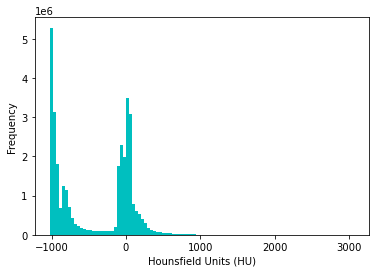

In [5]:
file_used= f'./fullimages_{patient_id}.npy'
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=100, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

### Critiquing the Histogram
The histogram suggests the following:

* There is lots of air (the reason why there are lot of values close to -1000 HU)
* There is some lung (denoted by the presence of values near -500 HU)
* There's an abundance of soft tissue, mostly muscle, liver, etc, but there's also some fat. 
* There is only a small bit of bone (seen as a tiny sliver of height between 700-3000)
This observation means that we will need to do significant preprocessing if we want to process lesions in the lung tissue because only a tiny bit of the voxels represent lung.

For reference:

|Substance|	HU|
| :--- | :--- |
|Air	|−1000|
|Lung	|−500|
|Fat	|−100 to −50|
|Water	|0|
|Blood	|+30 to +70|
|Muscle	|+10 to +40|
|Liver	|+40 to +60|
|Bone	|+700 (cancellous bone) to +3000 (cortical bone)|


Now if we have some values less than -1000 HU, then we have something strange. Because air really only goes to -1000, so there must be some sort of artifact.

Let's take a look at the actual images.

## Displaying an Image Stack
We don't have a lot of screen real estate, so we'll be skipping every 3 slices to get a representative look at the study.

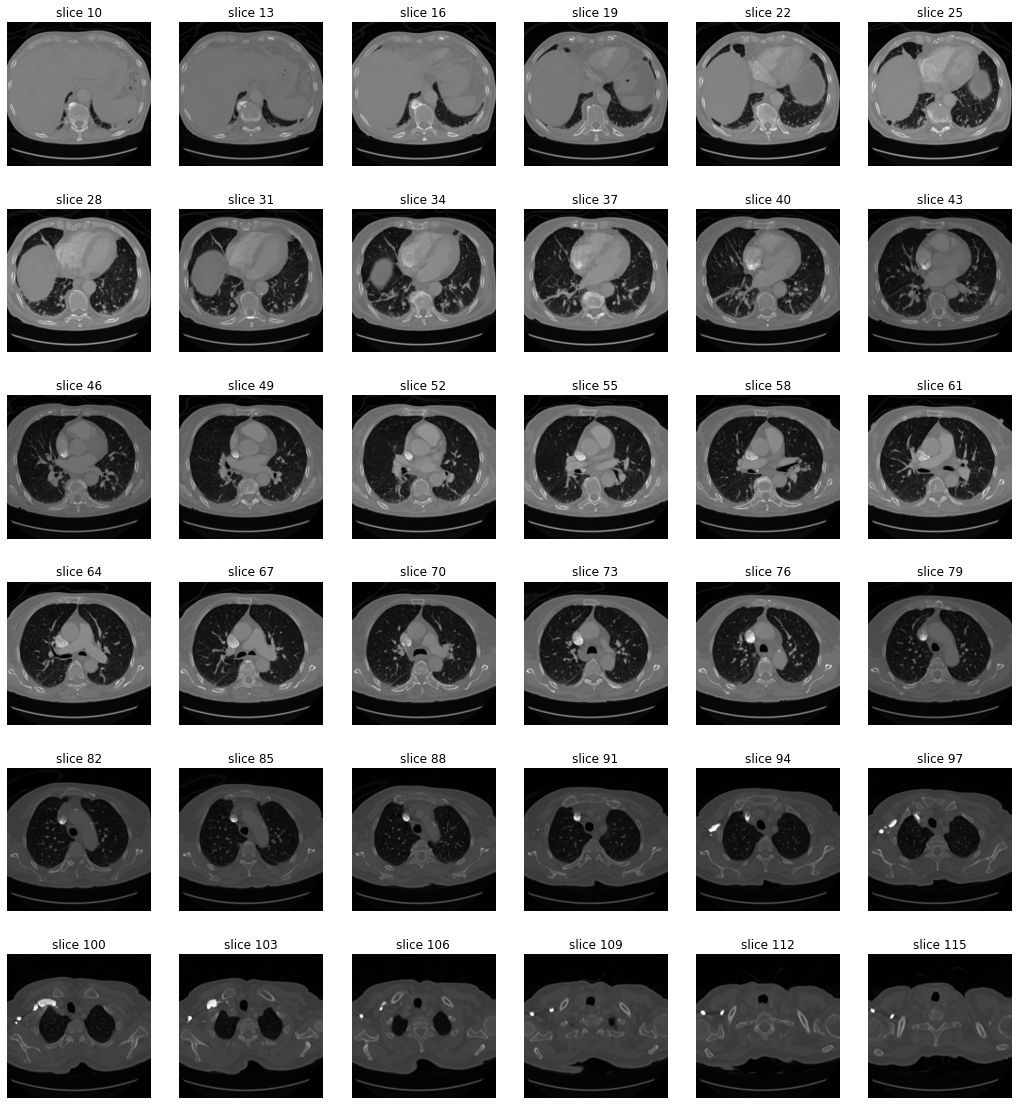

In [6]:
file_used= f'./fullimages_{patient_id}.npy'
imgs_to_process = np.load(file_used).astype(np.float64) 

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[18,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title(f'slice {ind}')
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

## Resampling
Although we have each individual slices, it is not immediately clear how thick each slice is. Fortunately, this is in the DICOM header.

In [7]:
print(f'Slice Thickness: {patient[0].SliceThickness}')
print(f'Pixel Spacing (row, col): ({patient[0].PixelSpacing[0]}, {patient[0].PixelSpacing[1]})')

Slice Thickness: 2.0
Pixel Spacing (row, col): (0.5234375, 0.5234375)


This means we have 2.0 mm slices, and each voxel represents 0.7 mm.

Because a CT slice is typically reconstructed at 512 x 512 voxels, each slice represents approximately 370 mm of data in length and width.

Using the metadata from the DICOM we can figure out the size of each voxel as the slice thickness. In order to display the CT in 3D isometric form (which we will do below), and also to compare between different scans, it would be useful to ensure that each slice is resampled in 1x1x1 mm pixels and slices.

In [8]:
np.array([float(patient[0].SliceThickness), float(patient[0].PixelSpacing[0]), float(patient[0].PixelSpacing[0])])

array([2.       , 0.5234375, 0.5234375])

In [9]:
file_used= f'./fullimages_{patient_id}.npy'
imgs_to_process = np.load(file_used).astype(np.float64)

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
#     spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array([float(patient[0].SliceThickness), 
                        float(patient[0].PixelSpacing[0]), 
                        float(patient[0].PixelSpacing[0])])


    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print(f'Shape before resampling: {imgs_to_process.shape}')
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print(f'Shape after resampling: {imgs_after_resamp.shape}')

Shape before resampling: (124, 512, 512)
Shape after resampling: (248, 268, 268)


In [10]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True)
    return verts, faces


def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = ff.create_trisurf(x=x, y=y, z=z, plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
#     ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    ax.set_facecolor((0.7,0.7,0.7))
    plt.show()

Here in the following part, I just have showed a 3D plot of the segmented bone just by using morphological analysis. 

* Tune the threshold in the following code block in order to get your desired part segmented. 
* If you want to see an static image of the 3D mesh plot, use the function `plt_3d()`. It takes less time but it is non interactive. That means you can't rotate and twist different axis for better view. 

* I you really want to see an interactive 3D mesh plot, just use the function `plotly_3d()` and comment out `plt_3d()`. **Caution: You can only see the interactive 3D plot after you commit the notebook in the kaggle notebook viewer. After the commit even, the interactive 3d plot takes a huge time (~12 mins with my 4Mbps internet)to load. ** 

Transposing surface
Calculating surface
Drawing


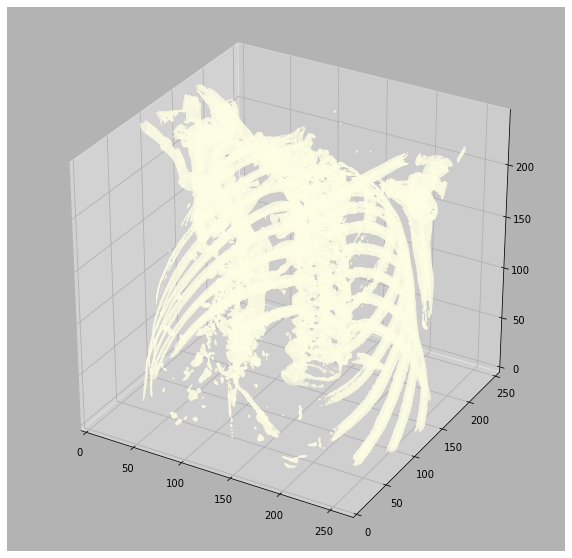

In [11]:
v, f = make_mesh(imgs_after_resamp, threshold = 350) #350 previously default value
plt_3d(v, f)
# plotly_3d(v, f)

## Segmentation
If you are interested in chest CTs because you're interested in picking up lung cancers, you're not alone. Machine learning algorithms work a lot better when you can narrowly define what it is looking at. One way to do this is by creating different models for different parts of a chest CT. For instance, a convolutional network for lungs would perform better than a general-purpose network for the whole chest. Therefore, it is often useful to pre-process the image data by auto-detecting the boundaries surrounding a volume of interest.

The below code will:

* Standardize the pixel value by subtracting the mean and dividing by the standard deviation
* Identify the proper threshold by creating 2 KMeans clusters comparing centered on soft tissue/bone vs lung/air.
* Using Erosion) and Dilation) which has the net effect of removing tiny features like pulmonary vessels or noise
* Identify each distinct region as separate image labels (think the magic wand in Photoshop)
* Using bounding boxes for each image label to identify which ones represent lung and which ones represent "every thing else"
* Create the masks for lung fields.
* Apply mask onto the original image to erase voxels outside of the lung fields.

In [12]:
def air_removal_mask(dilation):
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    if labels[0,0] == labels[-1, -1]:
        upper_cut = (labels==labels[0,0])
        mask = np.abs(upper_cut*1 -1) 
    else:
        upper_cut = (labels == labels[0,0])
        lower_cut = (labels == labels[-1,-1])
        mask = np.abs((upper_cut + lower_cut )*1 -1)      
    return mask

#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation [10,10]
    
    mask = dilation.astype('int16')*air_removal_mask(dilation)
    
    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img


### Single Slice Example At Each Step
We want to make sure the algorithm doesn't accidentally exclude the region of interest (due to its "soft tissue" nature). So let's test this out on a single slice.

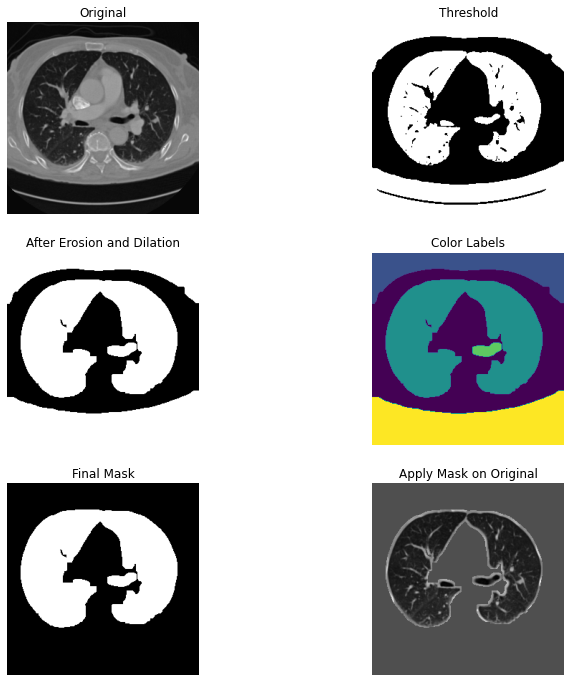

In [13]:
img = imgs_after_resamp[120]
output = make_lungmask(img, display=True)

### A few observations
If we were to apply a machine learning algorithm to the image stack, the algorithm would have a much easier time to identify a primary lung lesion. Downsides of using this mask appropach is you can miss hilar/perihilar disease fairly easily.

### Apply Masks to All Slices
The single-slice example seemed to work pretty well.
Let's now apply the mask to all the slices in this CT and show a few examples.


100%|██████████| 248/248 [00:29<00:00,  8.44it/s]


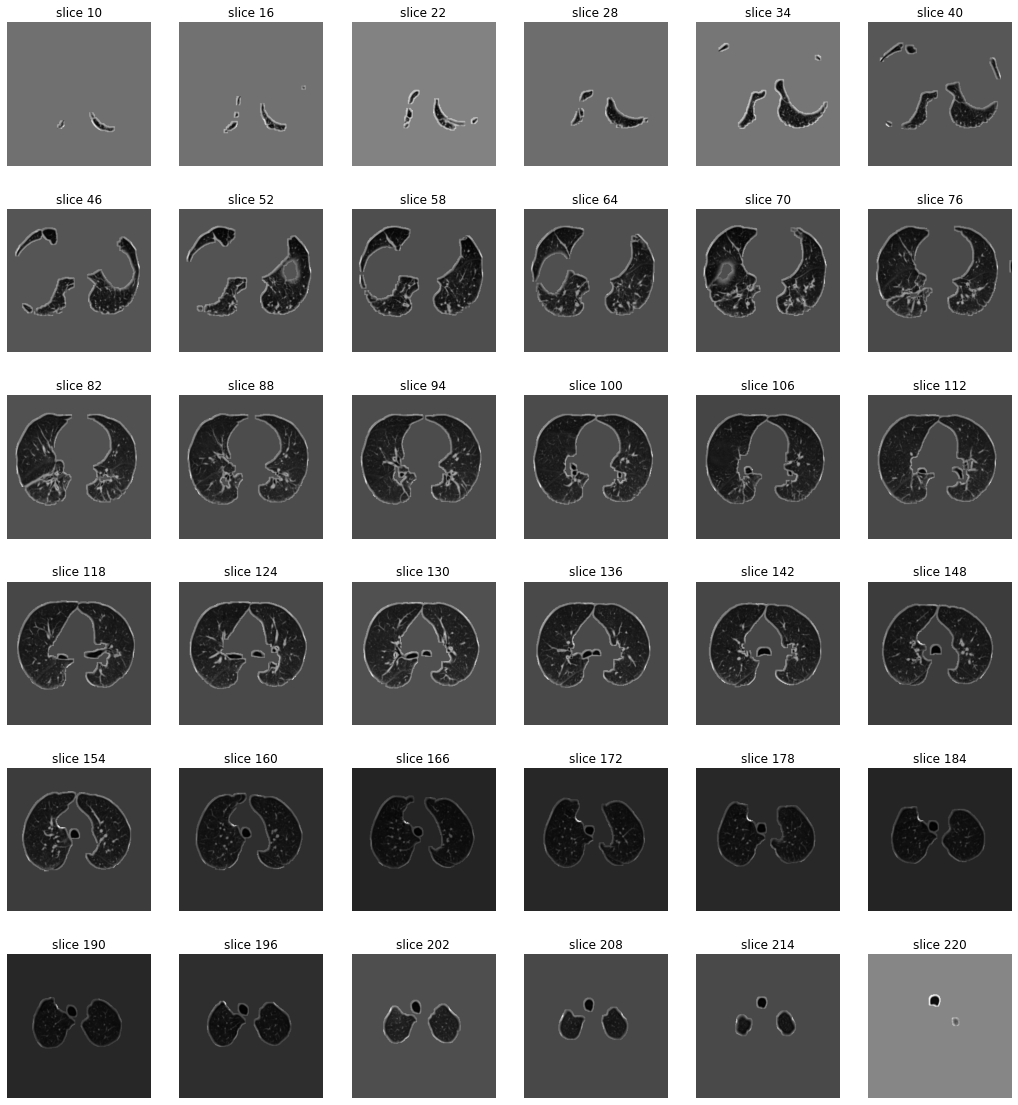

In [14]:
from tqdm import tqdm
masked_lung = []

for img in tqdm(imgs_after_resamp):
    masked_lung.append(make_lungmask(img))

sample_stack(masked_lung, show_every=6)

Looks like things check out. The lung lesion is properly preserved in the ROI, and it appears to work wel from lung bases all the way to the apices. This would be a good time to save the processed data.

In [15]:
np.save(f'maskedimages_{patient_id}.npy', masked_lung)

### Acknowledgements:
* [Guido Zuidhof](https://www.kaggle.com/gzuidhof/) for his excellent work on DICOM image processing. 
* [Howard Chen](https://www.raddq.com/author/howard/) for his excellent implementation of segmentation
* [Franklin Heng](https://medium.com/@hengloose/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed) for his master class explanation on segmentation and 3d plotting. 

![](https://www.clipartmax.com/png/middle/265-2655834_work-in-progress-icon.png)





### In the meantime, check out my other ongoing works in this same competition: 
💥 [RSNA-STR Pulmonary Embolism [Dummy Sub]](https://www.kaggle.com/redwankarimsony/rsna-str-pulmonary-embolism-dummy-sub)<br>
💥 [CT-Scans, DICOM files, Windowing Explained](https://www.kaggle.com/redwankarimsony/ct-scans-dicom-files-windowing-explained)<br>
💥 [RSNA-STR-PE [Gradient & Sigmoid Windowing]](https://www.kaggle.com/redwankarimsony/rsna-str-pe-gradient-sigmoid-windowing)<br>
💥 [RSNA-STR [✔️3D Stacking ✔️3D Plot ✔️Segmentation]](https://www.kaggle.com/redwankarimsony/rsna-str-3d-stacking-3d-plot-segmentation/edit/run/42517982)<br>
💥 [RSNA-STR [DICOM 👉 GIF 👉 npy]](https://www.kaggle.com/redwankarimsony/rsna-str-dicom-gif-npy)<br>
💥 [RSNA-STR Pulmonary Embolism [EDA]](https://www.kaggle.com/redwankarimsony/rsna-str-pulmonary-embolism-eda)<br>



In [16]:
import pandas as pd

PATH = "../input/rsna-str-pulmonary-embolism-detection/"
train = pd.read_csv(PATH + "train.csv")
sub = pd.read_csv(PATH + "sample_submission.csv")

feats = list(train.columns[3:5])+list(train.columns[8:12])+list(train.columns[13:17])
means = train[feats].mean().to_dict()


sub['label'] = 0.28
for feat in means.keys():
    sub.loc[sub.id.str.contains(feat, regex=False), 'label'] = means[feat]
    
sub.to_csv('submission.csv', index = False)
